<a href="https://colab.research.google.com/github/polymoe/datascientest/blob/main/3_Face_mask_detection_corrig%C3%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src="https://assets-datascientest.s3-eu-west-1.amazonaws.com/train/logo_datascientest.png" style="height:150px;center"></center>

<hr style="border-width:2px;border-color:#75DFC1">
<center><h1>Deep-Learning - Modules complémentaires</h1></center>
<center><h2>Détection de masque</h2></center>
<hr style="border-width:2px;border-color:#75DFC1">


Le but de cet exercice est de s'exercer au transfer learning.

 Nous allons travailler avec la base de données **```Face Mask Dataset```**. Cette base contient des images de personnes avec et sans masque de protection contre la Covid-19.

 Notez que les images ne sont pas stockées dans un DataFrame (comme lors de l'exercice sur l'âge et le genre). Nous avons directement accès aux liens des images. Nous allons pouvoir effectuer le preprocessing des images très rapidement avec des générateurs en utilisant la méthode ```flow_from_directory```.

> La structure de l'exercice est la suivante : 
>> I - [Traitement du dataset](#preparation)
>>> A - [Affichage des images](#affichage)
>>>
>>>
>>> B - [Générateurs](#generateurs)
>>
>>
>> II - [Classification](#classif)
>>
>>
>> III - [Test en temps réel](#test)

- Exécuter les cellules ci-dessous pour importer le dataset et les modules nécessaires à l'exercice.

In [ ]:
!wget https://assets-datascientest.s3-eu-west-1.amazonaws.com/datasets/Face+Mask+Dataset.zip
!unzip Face+Mask+Dataset.zip

--2022-01-03 14:03:33--  https://assets-datascientest.s3-eu-west-1.amazonaws.com/datasets/Face+Mask+Dataset.zip
Resolving assets-datascientest.s3-eu-west-1.amazonaws.com (assets-datascientest.s3-eu-west-1.amazonaws.com)... 52.218.101.208
Connecting to assets-datascientest.s3-eu-west-1.amazonaws.com (assets-datascientest.s3-eu-west-1.amazonaws.com)|52.218.101.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19487225 (19M) [application/zip]
Saving to: ‘Face+Mask+Dataset.zip’

Face+Mask+Dataset.z 100%[===================>]  18.58M  9.99MB/s    in 1.9s    

2022-01-03 14:03:36 (9.99 MB/s) - ‘Face+Mask+Dataset.zip’ saved [19487225/19487225]

Archive:  Face+Mask+Dataset.zip
  inflating: Face Mask Dataset/Train/WithMask/532.png  
  inflating: Face Mask Dataset/Train/WithMask/978.png  
  inflating: Face Mask Dataset/Train/WithMask/1100.png  
  inflating: Face Mask Dataset/Train/WithMask/963.png  
  inflating: Face Mask Dataset/Train/WithMask/915.png  
  inflating: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import image

from os import listdir
from os.path import isfile, join

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16

# I - <a name="preparation"></a> Traitement du dataset

## A - <a name="affichage"></a> Affichage des images

- (a) Exécuter la cellule suivante pour stocker dans des listes ```paths_with_mask``` et ```paths_without_mask``` les chemins des images du dataset.

In [ ]:
with_mask = 'Face Mask Dataset/Train/WithMask'
without_mask = 'Face Mask Dataset/Train/WithoutMask'

paths_with_mask = [join(with_mask, f) for f in listdir(with_mask) if isfile(join(with_mask, f))]
paths_without_mask = [join(without_mask, f) for f in listdir(without_mask) if isfile(join(without_mask, f))]

- (b) Utiliser les listes qui viennent d'être définies pour afficher des images d'indice aléatoire.
> - La fonction ```image.imread``` permet de transformer un lien en image, qui peut ensuite être affichée par ```plt.imshow```

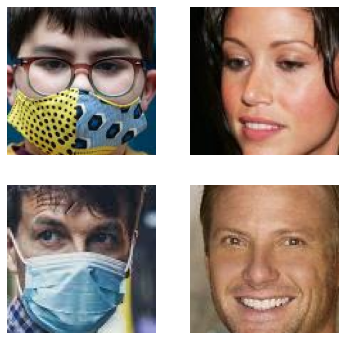

In [ ]:
plt.figure(figsize=(6,6))

plt.subplot(221)
plt.axis('off')
plt.imshow(image.imread(paths_with_mask[np.random.randint(len(paths_with_mask))]))

plt.subplot(222)
plt.axis('off')
plt.imshow(image.imread(paths_without_mask[np.random.randint(len(paths_without_mask))]))

plt.subplot(223)
plt.axis('off')
plt.imshow(image.imread(paths_with_mask[np.random.randint(len(paths_with_mask))]))

plt.subplot(224)
plt.axis('off')
plt.imshow(image.imread(paths_without_mask[np.random.randint(len(paths_without_mask))]));

## B - <a name="generateurs"></a> Générateurs

- (c) Définir trois générateurs :
> - ```train_data_generator``` avec les paramètres de transformation de votre choix (on prendra un ```validation_split``` de 0.2 et un scaling de 1/255) 
>
> - ```valid_data_generator``` avec un ```validation_split``` de 0.2 et un scaling de 1/255
>
> - ```test_data_generator``` avec un scaling de 1/255

In [ ]:
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,                      
                                   rotation_range=5,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

valid_data_generator = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_data_generator  = ImageDataGenerator(rescale = 1./255)

- (d) Implémenter sous les noms ```training_data```, ```valid_data``` et ```test_data``` des itérateurs des objets ```train_data_generator```, ```valid_data_generator``` et ```test_data_generator``` (utiliser la méthode ```flow```).
> - Les répertoires à utiliser sont ```'Face Mask Dataset/Train'```, ```'Face Mask Dataset/Validation'``` et ```'Face Mask Dataset/Test'```
>
> - On choisira une taille cible de (224, 224) (pour le ```VGG16```), une classe binaire (avec ou sans masque), et des lots de données de taille 32 (pour train et valid) ou 1 (pour test).

In [ ]:
training_data  = train_data_generator.flow_from_directory(directory = 'Face Mask Dataset/Train',
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   batch_size = 32)

valid_data = valid_data_generator.flow_from_directory(directory = 'Face Mask Dataset/Validation',
                                                  target_size = (224, 224),
                                                  class_mode = 'binary',
                                                  batch_size = 32)

test_data = test_data_generator.flow_from_directory(directory = 'Face Mask Dataset/Test',
                                                  target_size = (224, 224),
                                                  class_mode = 'binary',
                                                  batch_size = 1)

Found 654 images belonging to 2 classes.
Found 183 images belonging to 2 classes.
Found 166 images belonging to 2 classes.


# II - <a name="classif"></a> Classification

- (a) Importer le modèle ```VGG16``` et freezer ses couches.

- (b) Instancier un réseau de neurones (appelé ```model```), lui ajouter le modèle ```VGG16``` et ajouter les couches denses de votre choix.

- (c) Compiler le modèle avec une métrique appropriée.

- (d) Entraîner le modèle avec les paramètres de votre choix. On pourra également définir des callbacks.

- (e) Evaluer le modèle sur les données de test avec la méthode ```evaluate```.

In [ ]:
# Modèle VGG16
base_model = VGG16(weights='imagenet', include_top=False) 
# Freezer les couches du VGG16
for layer in base_model.layers: 
    layer.trainable = False

model = Sequential()
model.add(base_model) # Ajout du modèle VGG16
model.add(GlobalAveragePooling2D()) 
model.add(Flatten())
model.add(Dropout(rate=0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

58892288/58889256 [==============================] - 2s 0us/step


In [ ]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = 4,
                                         mode = 'min',
                                         restore_best_weights = True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                         patience=3,
                                         factor=0.5,
                                         verbose=2,
                                         mode='min',
                                         min_lr = 1e-10)

In [ ]:
model.compile(optimizer='Adam', loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(training_data, validation_data=valid_data, epochs=10, callbacks=[early_stopping,lr_plateau])

Epoch 1/10
21/21 [==============================] - 417s 20s/step - loss: 0.6884 - accuracy: 0.5306 - val_loss: 0.6300 - val_accuracy: 0.9126
Epoch 2/10
21/21 [==============================] - 413s 20s/step - loss: 0.6366 - accuracy: 0.7396 - val_loss: 0.5258 - val_accuracy: 0.8197
Epoch 3/10
21/21 [==============================] - 413s 20s/step - loss: 0.5279 - accuracy: 0.8130 - val_loss: 0.3266 - val_accuracy: 0.9016
Epoch 4/10
21/21 [==============================] - 413s 20s/step - loss: 0.3517 - accuracy: 0.8902 - val_loss: 0.1955 - val_accuracy: 0.9399
Epoch 5/10
21/21 [==============================] - 412s 20s/step - loss: 0.2342 - accuracy: 0.9092 - val_loss: 0.1512 - val_accuracy: 0.9508
Epoch 6/10
21/21 [==============================] - 414s 20s/step - loss: 0.1852 - accuracy: 0.9307 - val_loss: 0.1288 - val_accuracy: 0.9563
Epoch 7/10
21/21 [==============================] - 415s 20s/step - loss: 0.2011 - accuracy: 0.9210 - val_loss: 0.1207 - val_accuracy: 0.9563
Epoch 

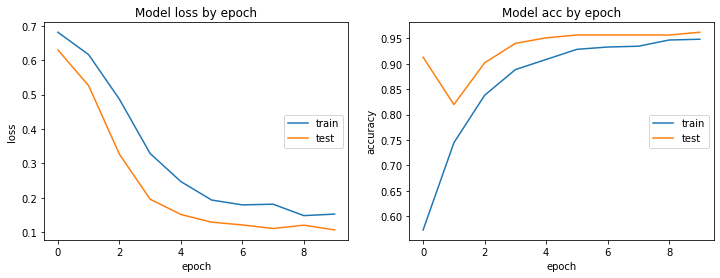

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [ ]:
model.evaluate(test_data)

166/166 [==============================] - 86s 518ms/step - loss: 0.1543 - accuracy: 0.9217


[0.15433886647224426, 0.9216867685317993]

# III - <a name="test"></a> Test en temps réel

- (a) Lancer les cellules suivantes pour tester votre modèle en direct sur votre webcam.

In [ ]:
labels_dict = {1 : 'No mask', 0 : 'Mask'}

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

def js_to_image(js_reply):
  image_bytes = b64decode(js_reply.split(',')[1])
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  img = cv2.imdecode(jpg_as_np, flags=1)
  return img

def bbox_to_bytes(bbox_array):
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  bbox_PIL.save(iobuf, format='png')
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))
  return bbox_bytes

def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
video_stream()
label_html = 'Capturing...'
bbox = ''
count = 0

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break
    img = js_to_image(js_reply["img"])
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    x, y, w, h = 220, 165, 200, 220
    face_img=img[y:y+w,x:x+w]
    resized=cv2.resize(face_img,(224,224))
    reshaped=np.reshape(resized,(1,224,224,3))
    result=model.predict(reshaped).round()[0][0]
    if result == 0:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(0,255,0),2)
      cv2.putText(bbox_array, labels_dict[result], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(0,255,0),2)
    if result == 1:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
      cv2.putText(bbox_array, labels_dict[result], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    bbox_bytes = bbox_to_bytes(bbox_array)
    bbox = bbox_bytes

<IPython.core.display.Javascript object>